Please upload a GRAYSCALE or COLOR image:


Saving parrot.PNG to parrot.PNG


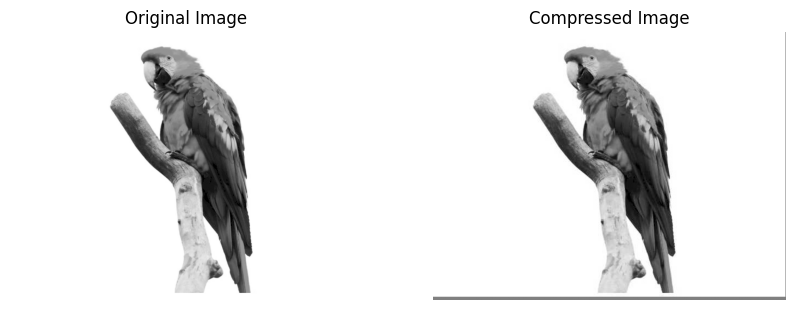

Compression Ratio (CR): 6.66
MSE: 226.43
PSNR: 24.58 dB
Rate Distortion (RD): 1699.76


In [ ]:
# =========================================
# JPEG-like DCT + Huffman Coding (Colab)
# Upload image FIRST, then process
# =========================================

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math
from collections import defaultdict

# ------------------------------
# IMAGE UPLOAD (USER INPUT)
# ------------------------------
print("Please upload a GRAYSCALE or COLOR image:")
uploaded = files.upload()

# Get uploaded image name
image_name = list(uploaded.keys())[0]

# Read image in grayscale
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)

# ------------------------------
# JPEG-LIKE DCT COMPRESSION
# ------------------------------
BLOCK = 8

Q = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=np.float32)

def block_process(img, func):
    h, w = img.shape
    output = np.zeros_like(img)
    for i in range(0, h, BLOCK):
        for j in range(0, w, BLOCK):
            block = img[i:i+BLOCK, j:j+BLOCK]
            if block.shape == (BLOCK, BLOCK):
                output[i:i+BLOCK, j:j+BLOCK] = func(block)
    return output

# Forward DCT
dct_img = block_process(image - 128, cv2.dct)

# Quantization
quantized = block_process(dct_img, lambda b: np.round(b / Q))

# Dequantization
dequantized = block_process(quantized, lambda b: b * Q)

# Inverse DCT
reconstructed = block_process(dequantized, cv2.idct) + 128
reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

# ------------------------------
# HUFFMAN CODING
# ------------------------------
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = defaultdict(int)
    for x in data.flatten():
        freq[int(x)] += 1

    heap = [HuffmanNode(k, v) for k, v in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        a = heapq.heappop(heap)
        b = heapq.heappop(heap)
        node = HuffmanNode(None, a.freq + b.freq)
        node.left = a
        node.right = b
        heapq.heappush(heap, node)

    return heap[0]

def generate_codes(node, code="", codes=None):
    if codes is None:
        codes = {}
    if node is not None:
        if node.symbol is not None:
            codes[node.symbol] = code
        generate_codes(node.left, code + "0", codes)
        generate_codes(node.right, code + "1", codes)
    return codes

tree = build_huffman_tree(quantized)
codes = generate_codes(tree)

encoded_bits = "".join(codes[int(x)] for x in quantized.flatten())

# ------------------------------
# METRICS
# ------------------------------
def mse(a, b):
    return np.mean((a - b) ** 2)

def psnr(mse_val):
    if mse_val == 0:
        return float('inf')
    return 20 * math.log10(255 / math.sqrt(mse_val))

original_bits = image.size * 8
compressed_bits = len(encoded_bits)

CR = original_bits / compressed_bits
MSE = mse(image, reconstructed)
PSNR = psnr(MSE)
RD = compressed_bits / MSE

# ------------------------------
# DISPLAY RESULTS
# ------------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image.astype(np.uint8), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed, cmap='gray')
plt.title("Compressed Image")
plt.axis('off')

plt.show()

print("Compression Ratio (CR):", round(CR, 2))
print("MSE:", round(MSE, 2))
print("PSNR:", round(PSNR, 2), "dB")
print("Rate Distortion (RD):", round(RD, 2))
